In [1]:

library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)



── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
pulsar_data <- read_csv("data/HTRU_2.csv")

Rows: 17897 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): 140.5625, 55.68378214, -0.234571412, -0.699648398, 3.199832776, 19....

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
colnames(pulsar_data) <- c('mean_profile', 'std_profile', 
                           'kurtosis_profile', 'skewness_profile', 
                           'mean_dmsnr', 'std_dmsnr', 'kurtosis_dmsnr', 
                           'skewness_dmsnr', "is_pulsar")


In [4]:
pulsar_data

mean_profile,std_profile,kurtosis_profile,skewness_profile,mean_dmsnr,std_dmsnr,kurtosis_dmsnr,skewness_dmsnr,is_pulsar
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
102.5078,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.0156,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.7500,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,0
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,0


In [5]:
select_pulsar_data<-pulsar_data|>
    select(mean_profile, kurtosis_profile, skewness_profile,is_pulsar)|>
    mutate(is_pulsar=as_factor(is_pulsar))

select_pulsar_data

mean_profile,kurtosis_profile,skewness_profile,is_pulsar
<dbl>,<dbl>,<dbl>,<fct>
102.5078,0.46531815,-0.5150879,0
103.0156,0.32332837,1.0511644,0
136.7500,-0.06841464,-0.6362384,0
⋮,⋮,⋮,⋮
119.3359,0.1593631,-0.74302540,0
114.5078,0.2011614,-0.02478884,0
57.0625,1.4063910,0.08951971,0


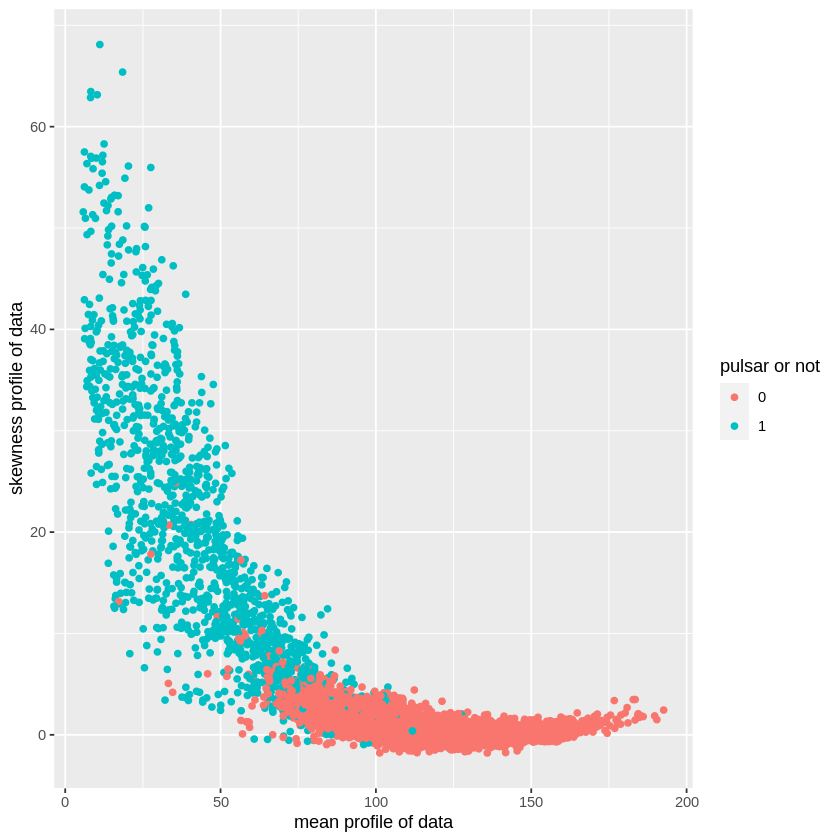

In [6]:
pulsar_plot <- select_pulsar_data |> 
ggplot(aes(x = mean_profile, y = skewness_profile, color = is_pulsar)) +
geom_point() + labs(x= "mean profile of data", y = "skewness profile of data", color = "pulsar or not")

pulsar_plot

In [8]:


set.seed(696)
select_pulsar_data_split <- initial_split(select_pulsar_data, prop = 0.75, strata = "is_pulsar")
select_pulsar_train_data <- training(select_pulsar_data_split)
select_pulsar_test_data <- testing(select_pulsar_data_split)

 


In [ ]:
select_pulsar_data_recipe <- recipe(is_pulsar ~ mean_profile + skewness_profile, data = select_pulsar_train_data) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

select_pulsar_kknn_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")



In [ ]:
select_pulsar_cv_folds <- vfold_cv(select_pulsar_train_data, v = 5)

select_pulsar_kknn_workflow <- workflow() %>%
  add_recipe(select_pulsar_data_recipe) %>%
  add_model(select_pulsar_kknn_model)

gridvals <- tibble(neighbors = seq(1, 50, by = 1))

select_pulsar_knn_tuning <- tune_grid(
  select_pulsar_kknn_workflow,
  resamples = select_pulsar_cv_folds,
  grid = gridvals
)

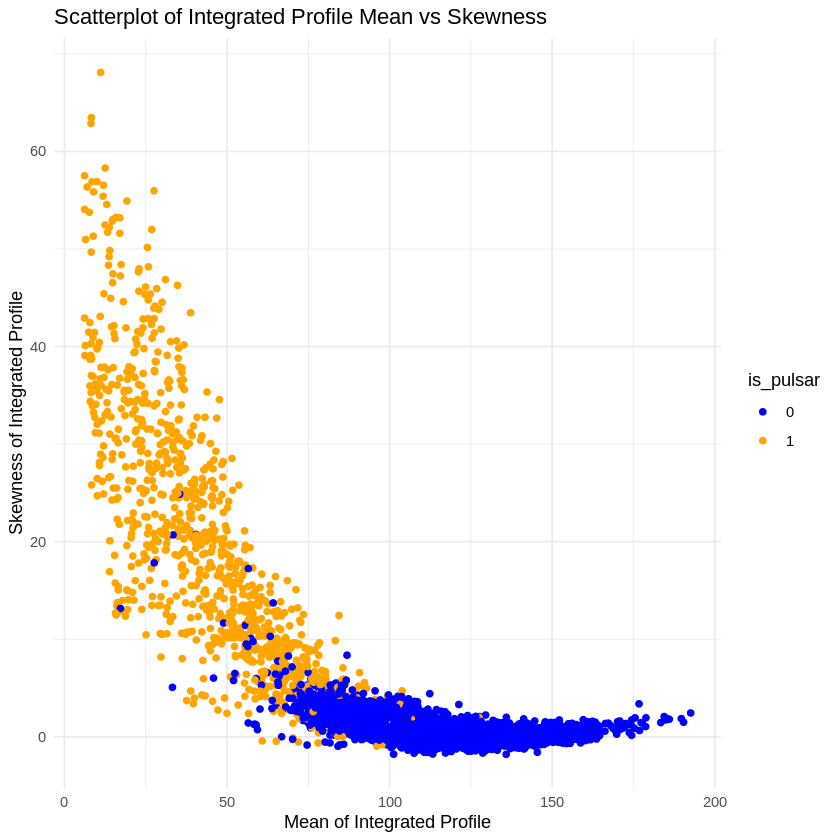

In [11]:
select_pulsar_best_kknn <- select_pulsar_knn_tuning %>%
  select_best("accuracy")

final_kknn_model <- finalize_model(select_pulsar_kknn_model, select_pulsar_best_kknn)

select_pulsar_data_plot <- ggplot(select_pulsar_train_data, aes(x = mean_profile, y = skewness_profile, color = is_pulsar)) +
  geom_point() +
  labs(title = "Scatterplot of Integrated Profile Mean vs Skewness",
       x = "Mean of Integrated Profile",
       y = "Skewness of Integrated Profile") +
  scale_color_manual(values = c("blue", "orange")) +
  theme_minimal()

select_pulsar_data_plot
